In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sdaia-kaust-ai-august-school-2022/README.md
/kaggle/input/sdaia-kaust-ai-august-school-2022/sample-submission.csv
/kaggle/input/sdaia-kaust-ai-august-school-2022/train.csv
/kaggle/input/sdaia-kaust-ai-august-school-2022/test.csv


In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter


In [3]:
DATA_DIR = pathlib.Path("../input/sdaia-kaust-ai-august-school-2022")


train_df = pd.read_csv(DATA_DIR / "train.csv", dtype="uint8")
test_df = pd.read_csv(DATA_DIR / "test.csv", dtype="uint8")


train_features = train_df.drop("labels", axis=1)
train_target = train_df.loc[:, "labels"]

In [4]:
class DataSetWithTransforms(Dataset):
    
    def __init__(self, features, target, feature_transforms=None):
        super().__init__()
        self._features = features
        self._target = torch.from_numpy(target).long()
        self._feature_transforms = feature_transforms
        
    def __getitem__(self, index):
        if self._feature_transforms is None:
            features = self._features[index]
            #feature = torch.rashape(feature, (32,32,3))
        else: 
            features = self._feature_transforms(self._features[index])
        target = self._target[index]
        return (features, target) 
    
    def __len__(self):
        n_samples, _ = self._features.shape
        return n_samples

In [5]:
class DataSetTest(Dataset):
    
    def __init__(self, features, feature_transforms=None):
        super().__init__()
        self._features = features
        self._feature_transforms = feature_transforms
        
    def __getitem__(self, index):
        if self._feature_transforms is None:
            features = self._features[index]
            #feature = torch.rashape(feature, (32,32,3))
        else: 
            features = self._feature_transforms(self._features[index])
        return (features) 
    
    def __len__(self):
        n_samples, _ = self._features.shape
        return n_samples

In [6]:
# data augmentation should only apply to training data
_feature_transforms = transforms.Compose([
    transforms.Lambda(lambda array: array.reshape((32, 32))),
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=15, scale=(1.0, 1.1)),
    transforms.ToTensor(),
])

train_dataset = DataSetWithTransforms(train_features.values, train_target.values, _feature_transforms)

In [7]:
train_loader=DataLoader(train_dataset,4)

In [8]:
# conveting test data only to tensor images should only apply to training data
_feature_transforms_test = transforms.Compose([
    transforms.Lambda(lambda array: array.reshape((32, 32))),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

test_dataset = DataSetTest(test_df.values, _feature_transforms_test)

In [9]:
test_loader=DataLoader(test_dataset,4)

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.l1 = nn.Linear(5 * 5 * 50, 1000)
        self.l2 = nn.Linear(1000, 500)
        self.l3 = nn.Linear(500, 29)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 5 * 5 * 50)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return x

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 9.0000e-02.
Iteataion 0: Training Accuracy: 29.977678571428573%
Adjusting learning rate of group 0 to 8.1000e-02.
Iteataion 1: Training Accuracy: 63.90625%
Adjusting learning rate of group 0 to 7.2900e-02.
Iteataion 2: Training Accuracy: 76.36904761904762%
Adjusting learning rate of group 0 to 6.5610e-02.
Iteataion 3: Training Accuracy: 82.3139880952381%
Adjusting learning rate of group 0 to 5.9049e-02.
Iteataion 4: Training Accuracy: 85.84821428571429%
Adjusting learning rate of group 0 to 5.3144e-02.
Iteataion 5: Training Accuracy: 88.02083333333334%
Adjusting learning rate of group 0 to 4.7830e-02.
Iteataion 6: Training Accuracy: 89.59077380952381%
Adjusting learning rate of group 0 to 4.3047e-02.
Iteataion 7: Training Accuracy: 90.69196428571429%
Adjusting learning rate of group 0 to 3.8742e-02.
Iteataion 8: Training Accuracy: 91.59970238095238%
Adjusting learning rate of group 0 to 3.4868e-02.


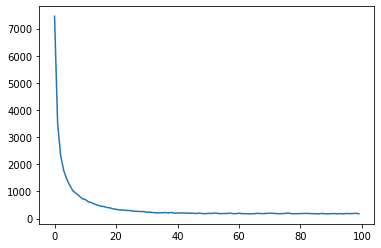

In [11]:
net = models.resnet18(num_classes=29)

net.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
device=torch.device('cuda:0')

net=net.to(device)
lr=0.1
momentum=0.0

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

ls = []
for i in range(100):
    loss_total = 0
    loss_val = 0
    acc_train = 0
    total_train = 0
    for ii, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]

        optimizer.zero_grad()
        data, label = data.to(device), label.to(device)
        logits = net(data)
        loss = F.cross_entropy(logits, label)
        loss_total += loss.item()
        loss.backward()
        optimizer.step()
        out = torch.argmax(logits, dim=1)
        acc_train += torch.sum(out == label)
        total_train += logits.shape[0]
    ls.append(loss_total)
    lr_scheduler.step()
    print(f"Iteataion {i}: Training Accuracy: {acc_train.item() / total_train * 100}%")

plt.plot(ls)
plt.show(block=True)
test_loader = DataLoader(test_dataset, 64)

predictions_list = list()


In [12]:
correct = 0 
total = 0 

for batch in train_loader:
    with torch.no_grad():
        x= batch [0].to (device)
        y= batch[1].to(device)

        correct +=( net(x).argmax(1)==y).sum().item()
        total+= x.shape[0]
print(correct/total*100)

98.28869047619048


In [13]:
prediction_list = list()
with torch.no_grad():
    for i,batch in enumerate(test_loader):
        data=batch
        data= data.to(device)
        logits = net(data)
        out=torch.argmax(logits, dim=1)
        prediction_list.append(out)
prediction_list = torch.cat(prediction_list).cpu()

test_features = pd.read_csv(DATA_DIR / "test.csv")
_ = (pd.DataFrame
       .from_dict({"Id": test_features.index, "Category": prediction_list})
       .to_csv("submission.csv", index=False))

## alternatively you could replace test_features.index by torch.arange(3360)